In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import os

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6 as of

import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 4



train_mu = [ 1.,  0.,  -0.5,   0.5 ]

train_rho = [ 
              [0.3, -0.2, 0.1   ],  #0
              [-0.5, 0.1],  #1
              [0.7],  #2
            ]

train_sig = [ 1., 0.7, 1.1, 0.8 ]





true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]


true_rho  = [ 
              [0.4, -0.3, 0.0   ],  #0
              [-0.4, 0.2],  #1
              [0.5],  #2
            ]





true_sig = [ 0.8, 0.6, 1.0,    0.6 ]




resolution = [ 0.4, 0.5, 0.6,   0.3  ]




train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                
ngen_train = 100000
ngen_true =  10000



ngen_train = 1000000
ngen_true =  100000


ngen_train = 4000000
ngen_true =  400000



#of_niter = 6
#of_niter = 12
#of_niter = 18
of_niter = 24

learning_rate_setval = 0.0005

#epochs_setval = 20
epochs_setval = 40

batch_size_setval = int( ngen_true )








 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *   -0.200 =  -0.2200
   0,  3 :              1.000 *    0.800 *    0.300 =   0.2400
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.100 =   0.0770
   1,  3 :              0.700 *    0.800 *   -0.500 =  -0.2800
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.700 =   0.6160
   3,  3 : diagonal    0.6400



 True covariance:
   0,  0 : diagonal    0.6400
   0,  1 :              0.800 *    0.600 *    0.000 =   0.0000
   0,  2 :              0.800 *    1.000 *   -0.300 =  -0.2400
   0,  3 :              0.800 *    0.600 *    0.400 =   0.1920
   1,  1 : diagonal    0.3600
   1,  2 :              0.600 *    1.000 *    0.200 =   0.1200
   1,  3 :              0.600 *    0.600 *   -0.400 =  -0.1440
   2,  2 : diagonal    1.0000
   2,  3 :              1.000 *    0.600 *    0.500 = 

In [4]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  -0.032785
True covariance determinant:   0.008427





In [5]:
train_cov_inv = np.linalg.inv( train_cov )

In [6]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [7]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.     0.07  -0.22   0.24 ]
 [ 0.07   0.49   0.077 -0.28 ]
 [-0.22   0.077  1.21   0.616]
 [ 0.24  -0.28   0.616  0.64 ]]

 Train covariance inverse
[[ -2.08333333   5.15873016  -4.41919192   7.29166667]
 [  5.15873016  -6.99168556   7.6960077  -12.40079365]
 [ -4.41919192   7.6960077   -5.93051729  10.73232323]
 [  7.29166667 -12.40079365  10.73232323 -16.92708333]]

 Train covariance inverse test
[[ 1.00000000e+00  2.16722583e-16  4.55348441e-16  8.23415410e-18]
 [-1.62555155e-16  1.00000000e+00  1.85452103e-16 -9.14939421e-16]
 [-7.47513162e-16  2.23786069e-15  1.00000000e+00  1.42849621e-15]
 [-1.70234197e-17  5.18597511e-16 -1.57629241e-16  1.00000000e+00]]





In [8]:
true_cov_inv = np.linalg.inv( true_cov )

In [9]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [10]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.64   0.    -0.24   0.192]
 [ 0.     0.36   0.12  -0.144]
 [-0.24   0.12   1.     0.3  ]
 [ 0.192 -0.144  0.3    0.36 ]]

 True covariance inverse
[[  7.22810039  -6.56167979   5.95472441 -11.44192913]
 [ -6.56167979  10.38932633  -6.82414698  13.34208224]
 [  5.95472441  -6.82414698   6.69291339 -11.48293963]
 [-11.44192913  13.34208224 -11.48293963  23.78608924]]

 True covariance inverse test
[[ 1.00000000e+00  1.06931087e-17  3.84294521e-18  6.20869935e-16]
 [-1.08503102e-16  1.00000000e+00  5.03893806e-16 -5.79643362e-16]
 [-4.05876120e-16  5.62415867e-16  1.00000000e+00 -4.41714323e-16]
 [-6.64687028e-16 -3.56436956e-17 -3.08869291e-16  1.00000000e+00]]





## Plots to visualize these parameter choices

In [11]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



/tmp/ipykernel_621955/1918166166.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)


<function matplotlib.pyplot.show(close=None, block=None)>

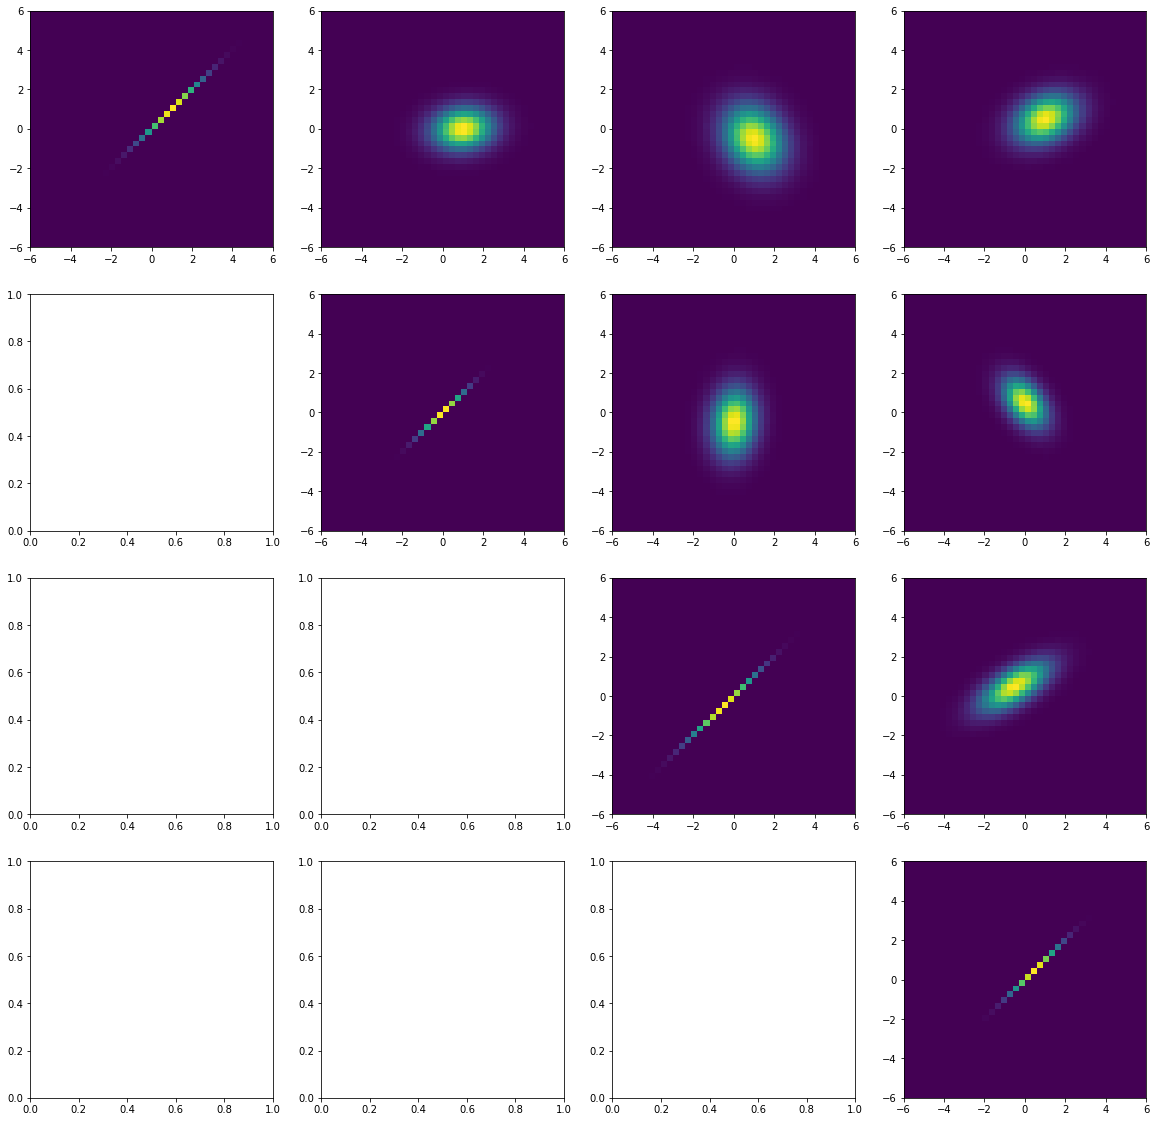

In [12]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

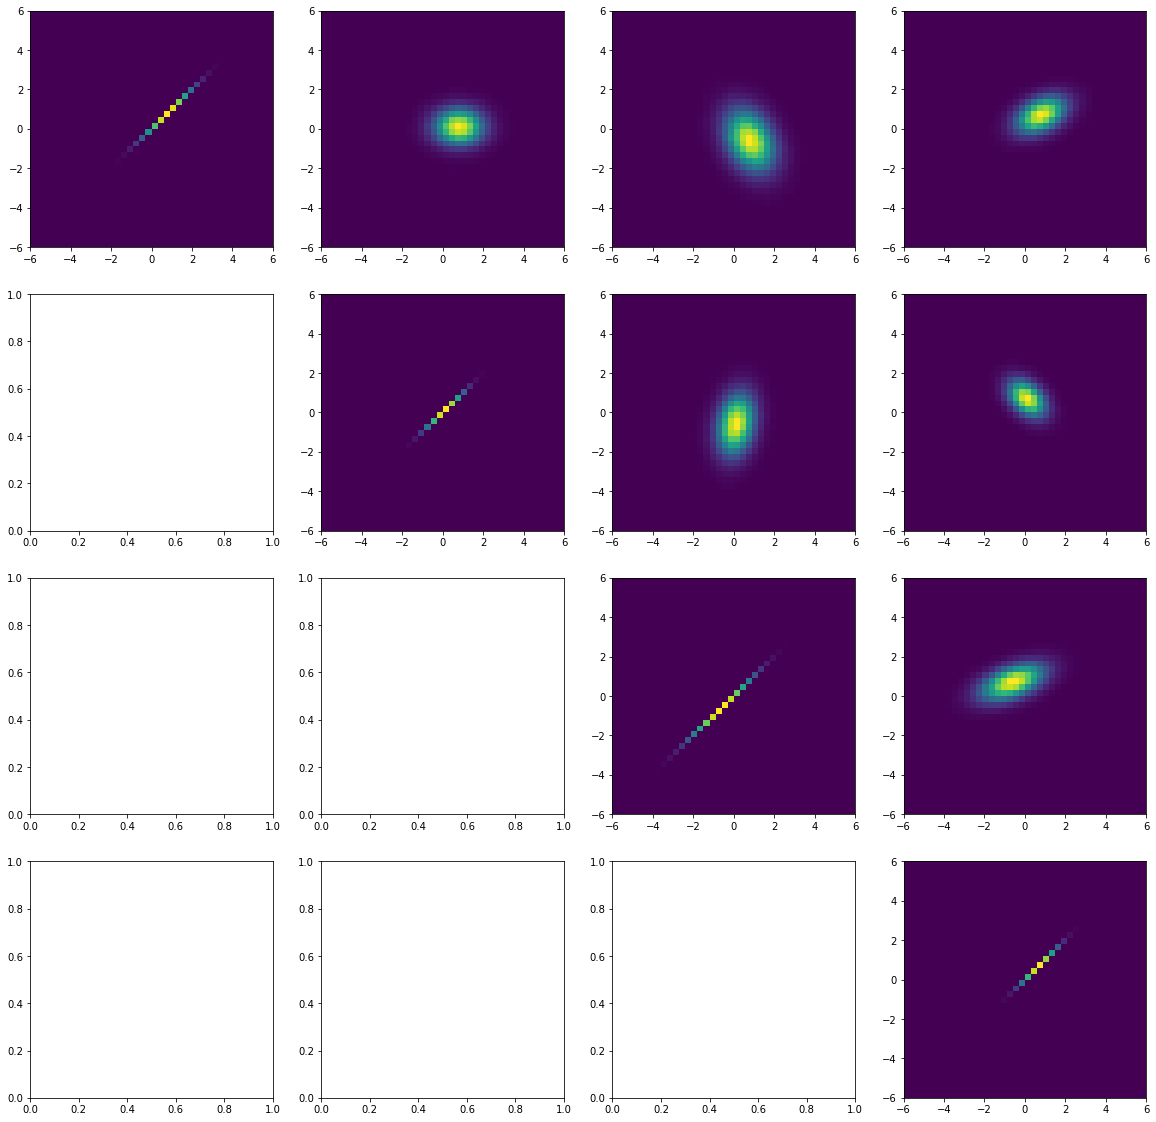

In [13]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

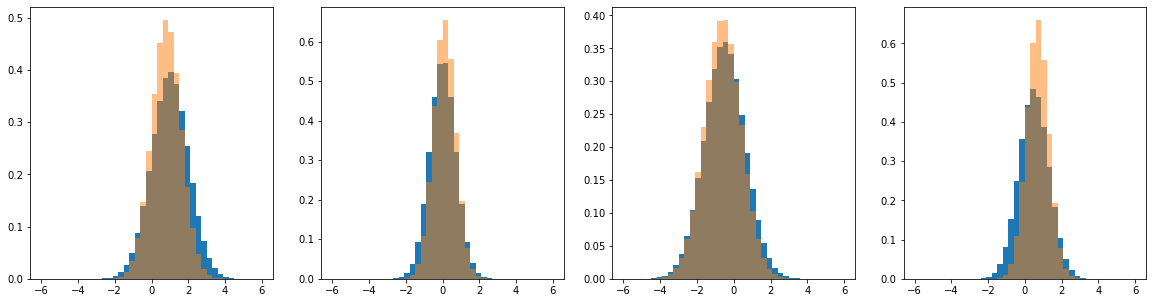

In [14]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [15]:
inputs = Input((4, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-05 10:26:47.505172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 10:26:47.522211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 10:26:47.522449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 10:26:47.525917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 10:26:47.526110: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [16]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [17]:
%%time


verbose = True






of_return_dict = of.omnifold6( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval )

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights






  ======== omnifold6


  shape of theta0_S : (4000000, 4)
  shape of theta_unknown_S : (400000, 4)
  shape of xvals_1 :  (4400000, 4)



  shape of labels0 : (4000000,)
  shape of labels_unknown : (400000,)
  shape of yvals_1 :  (4400000,)



  shape of theta0_G : (4000000, 4)
  shape of xvals_2 :  (8000000, 4)
  shape of yvals_2 :  (8000000,)

 batch size setval  400000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-05 10:26:51.349229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 10:26:51.353177: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efba40bc960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 10:26:51.353189: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-05 10:26:51.356663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 10:26:51.443717: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 9ms/step - loss: 0.7070 - accuracy: 0.3610
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6948 - accuracy: 0.6354
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.5519
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5205
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5550
             done pretraining.
Epoch 1/80
9/9 [==============================] - 1s 28ms/step - loss: 0.1257 - accuracy: 0.2657 - val_loss: 0.1254 - val_accuracy: 0.3066
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.3281 - val_loss: 0.1242 - val_accuracy: 0.3505
Epoch 3/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1234 - accuracy: 0.3584 - val_loss: 0.1228 - val_accuracy: 0.3662
Epoch 4/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1221

Epoch 56/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1113 - accuracy: 0.3448 - val_loss: 0.1115 - val_accuracy: 0.3452
Epoch 57/80
9/9 [==============================] - 0s 16ms/step - loss: 0.1113 - accuracy: 0.3442 - val_loss: 0.1115 - val_accuracy: 0.3464
Epoch 58/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1113 - accuracy: 0.3444 - val_loss: 0.1114 - val_accuracy: 0.3443
Epoch 59/80
9/9 [==============================] - 0s 15ms/step - loss: 0.1113 - accuracy: 0.3449 - val_loss: 0.1114 - val_accuracy: 0.3443
Epoch 60/80
9/9 [==============================] - 0s 15ms/step - loss: 0.1113 - accuracy: 0.3443 - val_loss: 0.1114 - val_accuracy: 0.3450
Epoch 61/80
9/9 [==============================] - 0s 15ms/step - loss: 0.1113 - accuracy: 0.3440 - val_loss: 0.1114 - val_accuracy: 0.3436
Epoch 62/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1113 - accuracy: 0.3439 - val_loss: 0.1114 - val_accuracy: 0.3456
Epoch 63/80
9/9 [===

15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3713 - val_loss: 0.6626 - val_accuracy: 0.3712
Epoch 30/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3713
Epoch 31/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3712
Epoch 32/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3713
Epoch 33/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3713
Epoch 34/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3713
Epoch 35/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.3714 - val_loss: 0.6626 - val_accuracy: 0.3713
Epoch 36/80
15/15 

9/9 [==============================] - 0s 26ms/step - loss: 0.1263 - accuracy: 0.2193 - val_loss: 0.1259 - val_accuracy: 0.2008
Epoch 2/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1254 - accuracy: 0.2014 - val_loss: 0.1249 - val_accuracy: 0.2164
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.2383 - val_loss: 0.1239 - val_accuracy: 0.2722
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1235 - accuracy: 0.2922 - val_loss: 0.1231 - val_accuracy: 0.3158
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1228 - accuracy: 0.3249 - val_loss: 0.1225 - val_accuracy: 0.3351
Epoch 6/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1222 - accuracy: 0.3387 - val_loss: 0.1220 - val_accuracy: 0.3428
Epoch 7/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1217 - accuracy: 0.3448 - val_loss: 0.1215 - val_accuracy: 0.3471
Epoch 8/40
9/9 [======================

Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 18/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.2500 - val_loss: 0.6864 - val_accuracy: 0.2501
Epoch 

Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.3624 - val_loss: 0.1209 - val_accuracy: 0.3627
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.3630 - val_loss: 0.1209 - val_accuracy: 0.3622
Epoch 30/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1207 - accuracy: 0.3617 - val_loss: 0.1209 - val_accuracy: 0.3624
Epoch 31/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1207 - accuracy: 0.3625 - val_loss: 0.1209 - val_accuracy: 0.3613
Epoch 32/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.3617 - val_loss: 0.1209 - val_accuracy: 0.3615
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.3612 - val_loss: 0.1209 - val_accuracy: 0.3611
Epoch 34/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.3612 - val_loss: 0.1209 - val_accuracy: 0.3621
Epoch 35/40
9/9 [===

400/400 [==============================] - 0s 654us/step

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[0.74860277 0.59013171 1.34749368 ... 2.06905528 0.41115681 0.03354086]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.7143 - accuracy: 0.4994
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6990 - accuracy: 0.4841
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6945 - accuracy: 0.4460
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6938 - accuracy: 0.4444
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.4622
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 25ms/step - loss: 0.1256 - accuracy: 0.2853 - val_loss: 0.1252 - val_accuracy: 0.2778
Epoch 2/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1250 - accur

15/15 [==============================] - 0s 10ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6899 - val_accuracy: 0.2500
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6899 - val_accuracy: 0.2501
Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2501
Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2501
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2501
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2501
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2501
Epoch 16/40
15/15 

Epoch 22/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1229 - accuracy: 0.3690 - val_loss: 0.1227 - val_accuracy: 0.3695
Epoch 23/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1229 - accuracy: 0.3686 - val_loss: 0.1227 - val_accuracy: 0.3677
Epoch 24/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1229 - accuracy: 0.3686 - val_loss: 0.1227 - val_accuracy: 0.3688
Epoch 25/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1229 - accuracy: 0.3684 - val_loss: 0.1227 - val_accuracy: 0.3674
Epoch 26/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1229 - accuracy: 0.3678 - val_loss: 0.1227 - val_accuracy: 0.3673
Epoch 27/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1229 - accuracy: 0.3673 - val_loss: 0.1227 - val_accuracy: 0.3670
Epoch 28/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1228 - accuracy: 0.3672 - val_loss: 0.1227 - val_accuracy: 0.3666
Epoch 29/40
9/9 [===

15/15 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 36/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 37/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 38/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 40/40
400/400 [==============================] - 0s 650us/step

ITERATION: 6

   -- ITERATION 6  STEP 1

 weights_push at the beginning
[0.53873945 0.29041297 1.37297411 ... 2.36653145 0.31984582 0.01739605]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [=============

15/15 [==============================] - 0s 12ms/step - loss: 0.6916 - accuracy: 0.2500 - val_loss: 0.6918 - val_accuracy: 0.2502
Epoch 4/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2499 - val_loss: 0.6917 - val_accuracy: 0.2502
Epoch 5/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6916 - val_accuracy: 0.2501
Epoch 6/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6916 - val_accuracy: 0.2501
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6916 - val_accuracy: 0.2501
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6916 - val_accuracy: 0.2501
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6916 - val_accuracy: 0.2501
Epoch 10/40
15/15 [=====

9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3788 - val_loss: 0.1245 - val_accuracy: 0.3781
Epoch 16/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1246 - accuracy: 0.3778 - val_loss: 0.1245 - val_accuracy: 0.3768
Epoch 17/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1246 - accuracy: 0.3777 - val_loss: 0.1245 - val_accuracy: 0.3777
Epoch 18/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3784 - val_loss: 0.1245 - val_accuracy: 0.3769
Epoch 19/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3769 - val_loss: 0.1245 - val_accuracy: 0.3758
Epoch 20/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1245 - accuracy: 0.3768 - val_loss: 0.1244 - val_accuracy: 0.3755
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1245 - accuracy: 0.3762 - val_loss: 0.1244 - val_accuracy: 0.3755
Epoch 22/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 29/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 31/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 32/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 33/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 34/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2499
Epoch 35/40
15/15 

400/400 [==============================] - 0s 663us/step

   -- ITERATION 8  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 9ms/step - loss: 0.6979 - accuracy: 0.3197
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6967 - accuracy: 0.3575
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.3956
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6953 - accuracy: 0.4297
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6950 - accuracy: 0.4575
             done pretraining.
Epoch 1/40
15/15 [==============================] - 0s 17ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6951 - val_accuracy: 0.2497
Epoch 2/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.2500 - val_loss: 0.6947 - val_accuracy: 0.2498
Epoch 3/40
15/15 [==============================] - 0s 11ms

Epoch 9/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1252 - accuracy: 0.3804 - val_loss: 0.1252 - val_accuracy: 0.3817
Epoch 10/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1252 - accuracy: 0.3839 - val_loss: 0.1251 - val_accuracy: 0.3839
Epoch 11/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1252 - accuracy: 0.3822 - val_loss: 0.1251 - val_accuracy: 0.3801
Epoch 12/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3808 - val_loss: 0.1251 - val_accuracy: 0.3814
Epoch 13/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3822 - val_loss: 0.1251 - val_accuracy: 0.3819
Epoch 14/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3810 - val_loss: 0.1251 - val_accuracy: 0.3797
Epoch 15/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3806 - val_loss: 0.1251 - val_accuracy: 0.3810
Epoch 16/40
9/9 [====

15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 23/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 24/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 25/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 26/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 27/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 28/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.2500 - val_loss: 0.6914 - val_accuracy: 0.2501
Epoch 29/40
15/15 

Epoch 35/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1250 - accuracy: 0.3588 - val_loss: 0.1247 - val_accuracy: 0.3594
Epoch 36/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1250 - accuracy: 0.3630 - val_loss: 0.1247 - val_accuracy: 0.3609
Epoch 37/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1250 - accuracy: 0.3595 - val_loss: 0.1247 - val_accuracy: 0.3599
Epoch 38/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1250 - accuracy: 0.3630 - val_loss: 0.1247 - val_accuracy: 0.3584
Epoch 39/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1250 - accuracy: 0.3584 - val_loss: 0.1247 - val_accuracy: 0.3573
Epoch 40/40
400/400 [==============================] - 0s 680us/step

   -- ITERATION 10  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6963 - accuracy: 0.3488
Epoch 2/5
15/15 [==============================

Epoch 3/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1257 - accuracy: 0.3701 - val_loss: 0.1255 - val_accuracy: 0.3717
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3684 - val_loss: 0.1255 - val_accuracy: 0.3710
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1256 - accuracy: 0.3749 - val_loss: 0.1254 - val_accuracy: 0.3815
Epoch 6/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1256 - accuracy: 0.3837 - val_loss: 0.1254 - val_accuracy: 0.3856
Epoch 7/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1255 - accuracy: 0.3863 - val_loss: 0.1253 - val_accuracy: 0.3838
Epoch 8/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3819 - val_loss: 0.1253 - val_accuracy: 0.3792
Epoch 9/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3785 - val_loss: 0.1253 - val_accuracy: 0.3788
Epoch 10/40
9/9 [==========

Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 22/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 23/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6927 - val_accuracy: 0.2503
Epoch 

Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3736 - val_loss: 0.1259 - val_accuracy: 0.3731
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3707 - val_loss: 0.1259 - val_accuracy: 0.3727
Epoch 32/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3757 - val_loss: 0.1259 - val_accuracy: 0.3779
Epoch 33/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3710 - val_loss: 0.1259 - val_accuracy: 0.3700
Epoch 34/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3746 - val_loss: 0.1259 - val_accuracy: 0.3773
Epoch 35/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3738 - val_loss: 0.1259 - val_accuracy: 0.3710
Epoch 36/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3763 - val_loss: 0.1259 - val_accuracy: 0.3739
Epoch 37/40
9/9 [===

15/15 [==============================] - 1s 8ms/step - loss: 0.6949 - accuracy: 0.4994
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.4680
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4572
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4773
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4935
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 26ms/step - loss: 0.1261 - accuracy: 0.2492 - val_loss: 0.1261 - val_accuracy: 0.3049
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3604 - val_loss: 0.1261 - val_accuracy: 0.3977
Epoch 3/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1260 - accuracy: 0.3975 - val_loss: 0.1260 - val_accuracy: 0.3900
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260

15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.2501 - val_loss: 0.6903 - val_accuracy: 0.2498
Epoch 18/40
15/15 

9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3680 - val_loss: 0.1257 - val_accuracy: 0.3737
Epoch 24/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3782 - val_loss: 0.1257 - val_accuracy: 0.3786
Epoch 25/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3757 - val_loss: 0.1257 - val_accuracy: 0.3702
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3705 - val_loss: 0.1257 - val_accuracy: 0.3703
Epoch 27/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3718 - val_loss: 0.1257 - val_accuracy: 0.3730
Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3685 - val_loss: 0.1257 - val_accuracy: 0.3690
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3722 - val_loss: 0.1257 - val_accuracy: 0.3721
Epoch 30/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6897 - accuracy: 0.2499 - val_loss: 0.6878 - val_accuracy: 0.2502
Epoch 37/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6897 - accuracy: 0.2499 - val_loss: 0.6878 - val_accuracy: 0.2501
Epoch 38/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6897 - accuracy: 0.2500 - val_loss: 0.6878 - val_accuracy: 0.2501
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6897 - accuracy: 0.2500 - val_loss: 0.6878 - val_accuracy: 0.2501
Epoch 40/40
400/400 [==============================] - 0s 673us/step

ITERATION: 15

   -- ITERATION 15  STEP 1

 weights_push at the beginning
[1.49989097e-01 3.79774262e-02 9.24251776e-01 ... 2.53212893e+00
 1.76764164e-01 1.96069029e-03]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.4915
Epoch 2/5
15/15 [==============================]

15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 5/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2497
Epoch 6/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2497
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 11/40
15/15 [====

9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3874 - val_loss: 0.1259 - val_accuracy: 0.3873
Epoch 17/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3930 - val_loss: 0.1259 - val_accuracy: 0.3865
Epoch 18/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3828 - val_loss: 0.1259 - val_accuracy: 0.3797
Epoch 19/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1261 - accuracy: 0.3881 - val_loss: 0.1259 - val_accuracy: 0.3916
Epoch 20/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3915 - val_loss: 0.1259 - val_accuracy: 0.3903
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3963 - val_loss: 0.1259 - val_accuracy: 0.3716
Epoch 22/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3574 - val_loss: 0.1259 - val_accuracy: 0.3863
Epoch 23/40
9/9 [===============

15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2499
Epoch 30/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 31/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 32/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 33/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 34/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 35/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6926 - val_accuracy: 0.2500
Epoch 36/40
15/15 

15/15 [==============================] - 1s 8ms/step - loss: 0.6938 - accuracy: 0.4204
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4876
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5320
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5529
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5550
             done pretraining.
Epoch 1/40
15/15 [==============================] - 0s 19ms/step - loss: 0.6955 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2499
Epoch 2/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2500
Epoch 3/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2500
Epoch 4/40
15/15 [==============================] - 0s 11ms/step - loss

Epoch 10/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.3978 - val_loss: 0.1265 - val_accuracy: 0.3906
Epoch 11/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.3965 - val_loss: 0.1265 - val_accuracy: 0.3969
Epoch 12/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1265 - accuracy: 0.3984 - val_loss: 0.1265 - val_accuracy: 0.3955
Epoch 13/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.3873 - val_loss: 0.1265 - val_accuracy: 0.3989
Epoch 14/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.4014 - val_loss: 0.1265 - val_accuracy: 0.3994
Epoch 15/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.3891 - val_loss: 0.1265 - val_accuracy: 0.3894
Epoch 16/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1265 - accuracy: 0.3937 - val_loss: 0.1265 - val_accuracy: 0.3914
Epoch 17/40
9/9 [===

15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 24/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 25/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 26/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 27/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 28/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 29/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6983 - accuracy: 0.2501 - val_loss: 0.6963 - val_accuracy: 0.2498
Epoch 30/40
15/15 

Epoch 36/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.3671 - val_loss: 0.1264 - val_accuracy: 0.3506
Epoch 37/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.3459 - val_loss: 0.1264 - val_accuracy: 0.3714
Epoch 38/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.3844 - val_loss: 0.1264 - val_accuracy: 0.3682
Epoch 39/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.3679 - val_loss: 0.1264 - val_accuracy: 0.3519
Epoch 40/40
400/400 [==============================] - 0s 653us/step

   -- ITERATION 19  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6935 - accuracy: 0.3808
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.4745
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 

9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3657 - val_loss: 0.1260 - val_accuracy: 0.3543
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3529 - val_loss: 0.1260 - val_accuracy: 0.3736
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.4018 - val_loss: 0.1260 - val_accuracy: 0.3906
Epoch 6/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3626 - val_loss: 0.1260 - val_accuracy: 0.3483
Epoch 7/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3605 - val_loss: 0.1260 - val_accuracy: 0.3873
Epoch 8/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3881 - val_loss: 0.1260 - val_accuracy: 0.3714
Epoch 9/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3636 - val_loss: 0.1260 - val_accuracy: 0.3756
Epoch 10/40
9/9 [=====================

Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2501
Epoch 22/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 23/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.2499 - val_loss: 0.6945 - val_accuracy: 0.2502
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3053 - val_loss: 0.1259 - val_accuracy: 0.3245
Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3545 - val_loss: 0.1259 - val_accuracy: 0.3356
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3058 - val_loss: 0.1259 - val_accuracy: 0.3135
Epoch 32/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3419 - val_loss: 0.1259 - val_accuracy: 0.3319
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3329 - val_loss: 0.1259 - val_accuracy: 0.3001
Epoch 34/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.2946 - val_loss: 0.1259 - val_accuracy: 0.3343
Epoch 35/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1249 - accuracy: 0.3458 - val_loss: 0.1259 - val_accuracy: 0.3091
Epoch 36/40
9/9 [===============

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6934 - accuracy: 0.5192
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5008
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4928
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5047
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5051
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 27ms/step - loss: 0.1263 - accuracy: 0.3729 - val_loss: 0.1265 - val_accuracy: 0.3894
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1263 - accuracy: 0.3741 - val_loss: 0.1265 - val_accuracy: 0.3513
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1263 - accuracy: 0.3596 - val_loss: 0.1265 - val_accuracy: 0.3635
Epoch 4/4

Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2500 - val_loss: 0.7008 - val_accuracy: 0.2499
Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2500 - val_loss: 0.7008 - val_accuracy: 0.2499
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2500 - val_loss: 0.7008 - val_accuracy: 0.2498
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2501 - val_loss: 0.7008 - val_accuracy: 0.2499
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2500 - val_loss: 0.7008 - val_accuracy: 0.2498
Epoch 16/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6975 - accuracy: 0.2500 - val_loss: 0.7008 - val_accuracy: 0.2498
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.2501 - val_loss: 0.7008 - val_accuracy: 0.2498
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1266 - accuracy: 0.3796 - val_loss: 0.1263 - val_accuracy: 0.3801
Epoch 24/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1266 - accuracy: 0.3745 - val_loss: 0.1263 - val_accuracy: 0.3849
Epoch 25/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1266 - accuracy: 0.3983 - val_loss: 0.1263 - val_accuracy: 0.3725
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1266 - accuracy: 0.3619 - val_loss: 0.1263 - val_accuracy: 0.3730
Epoch 27/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1266 - accuracy: 0.3876 - val_loss: 0.1263 - val_accuracy: 0.3930
Epoch 28/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1266 - accuracy: 0.3765 - val_loss: 0.1263 - val_accuracy: 0.3565
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1266 - accuracy: 0.3722 - val_loss: 0.1263 - val_accuracy: 0.3825
Epoch 30/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2499
Epoch 37/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2499
Epoch 38/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2499
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2499
Epoch 40/40
400/400 [==============================] - 0s 650us/step

ITERATION: 24

   -- ITERATION 24  STEP 1

 weights_push at the beginning
[8.94700760e-02 2.52381238e-02 8.69190669e-01 ... 2.40940811e+00
 1.52480156e-01 5.78663981e-04]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6934 - accuracy: 0.4851
Epoch 2/5
15/15 [==============================]

15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2498
Epoch 5/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2498
Epoch 6/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2499
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2498
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2501 - val_loss: 0.6863 - val_accuracy: 0.2499
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2499
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.2500 - val_loss: 0.6863 - val_accuracy: 0.2499
Epoch 11/40
15/15 [====

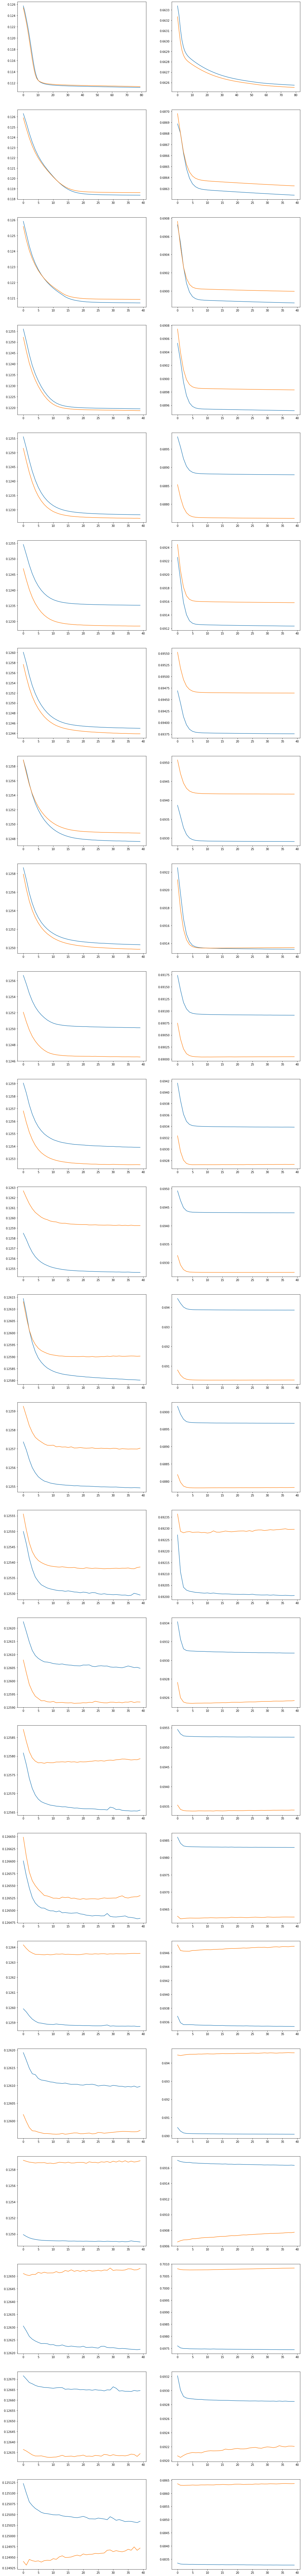

In [18]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

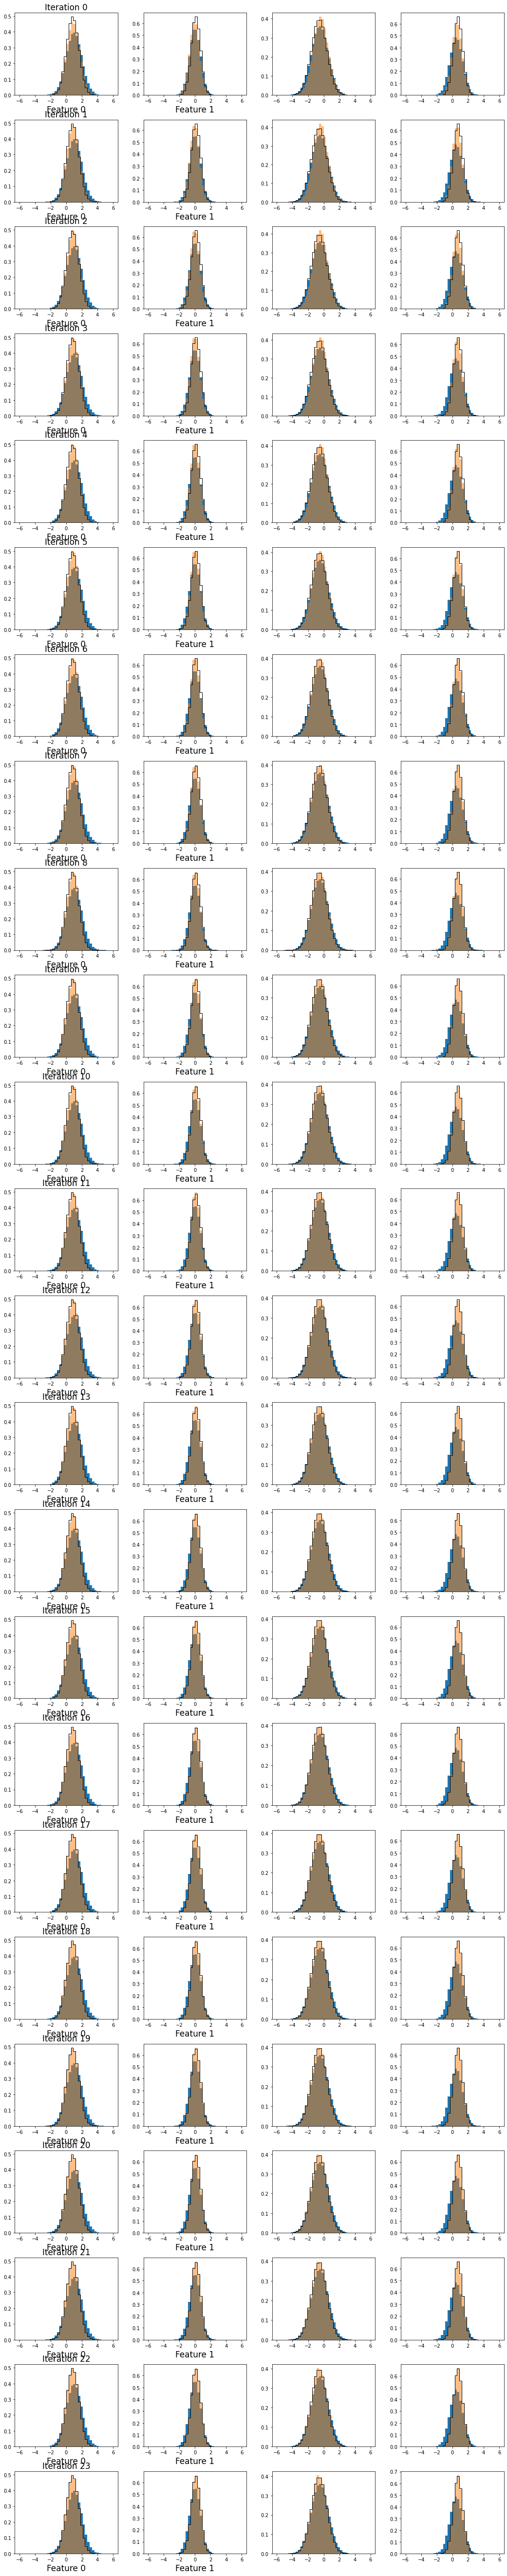

In [19]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [20]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

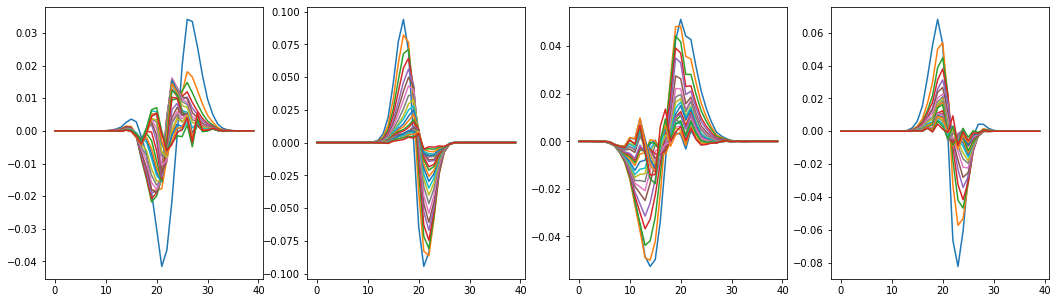

In [21]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

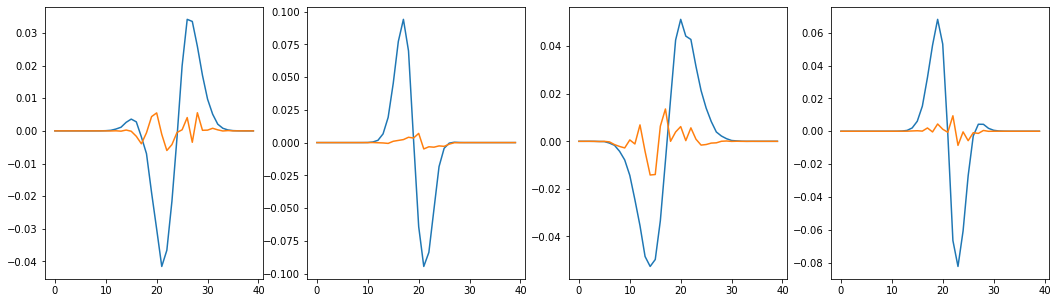

In [22]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

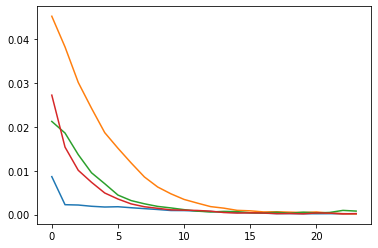

In [23]:
plt.plot( hist_data_sum_diff2)

<function matplotlib.pyplot.show(close=None, block=None)>

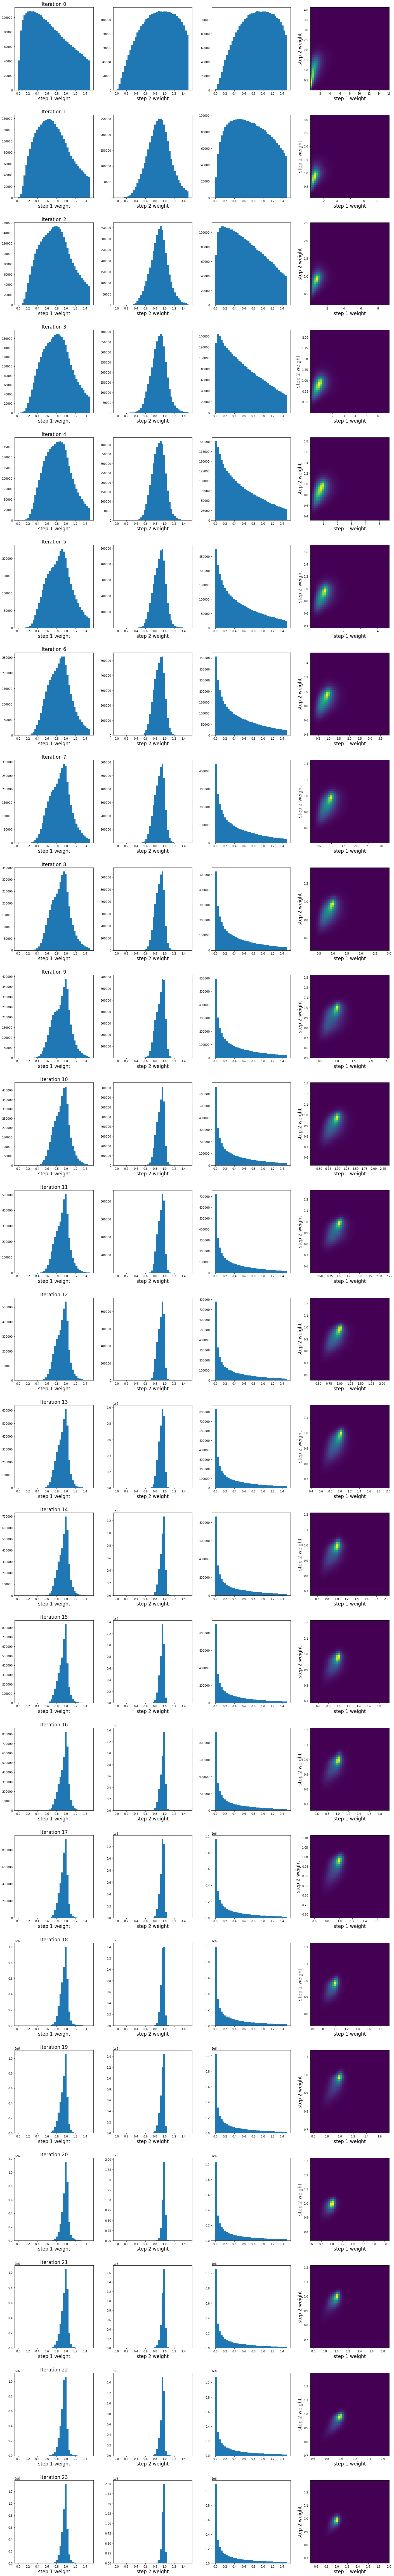

In [24]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

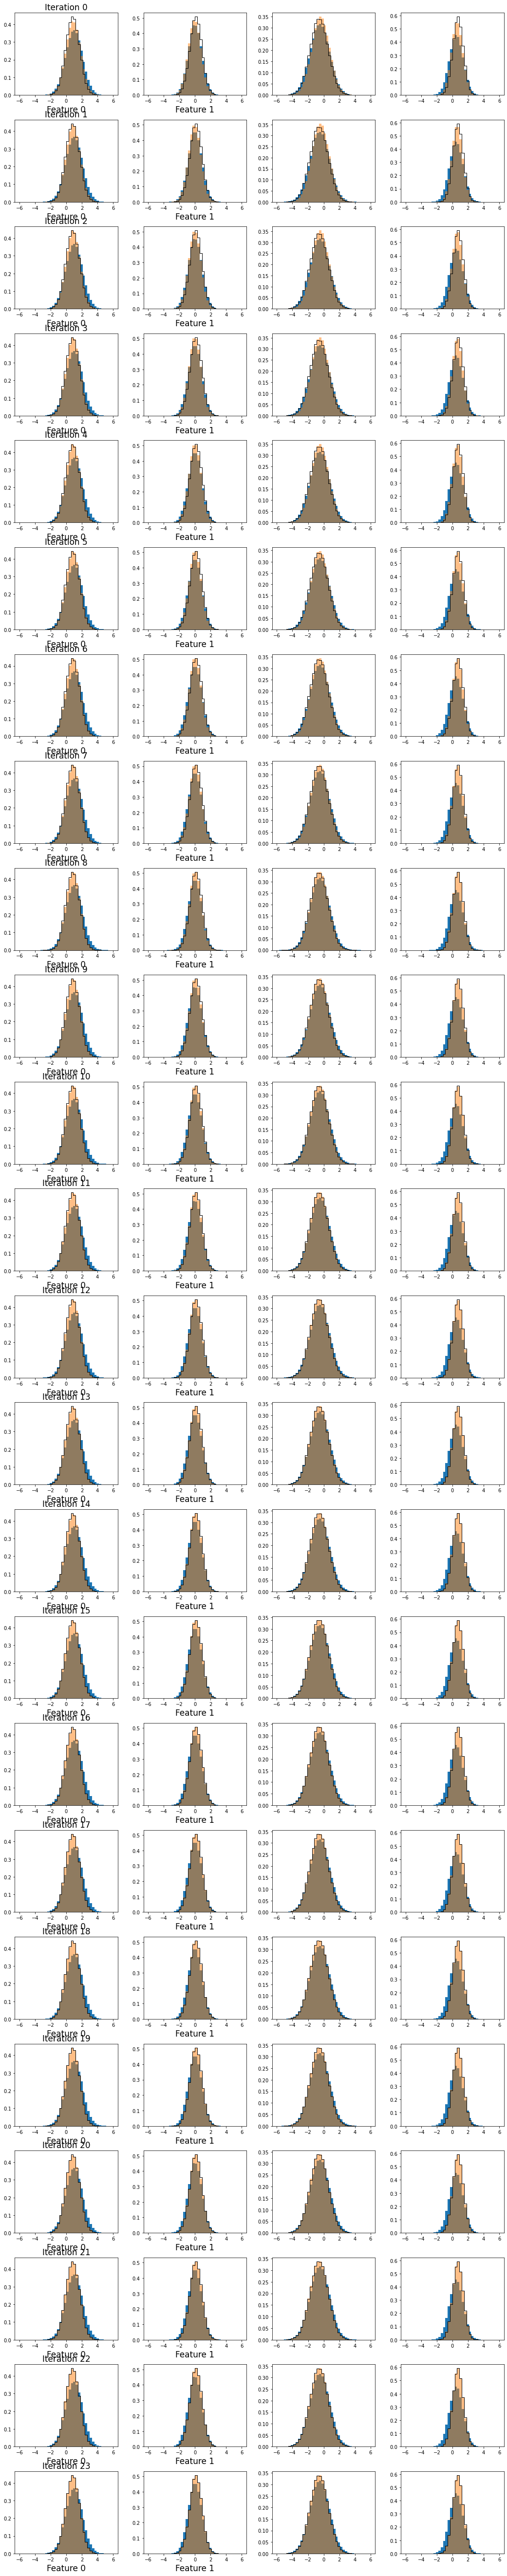

In [25]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [26]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

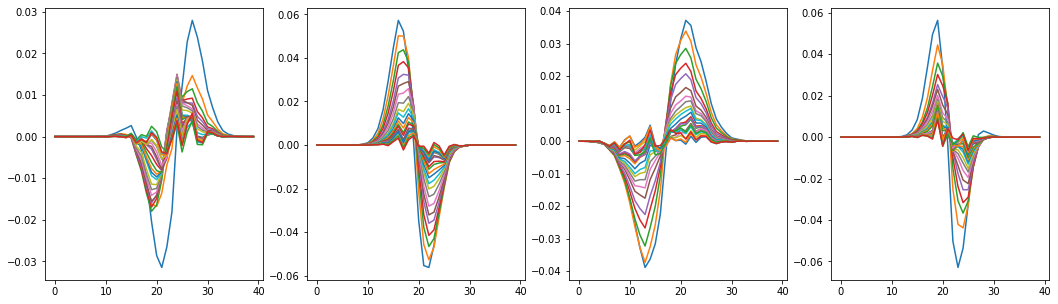

In [27]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

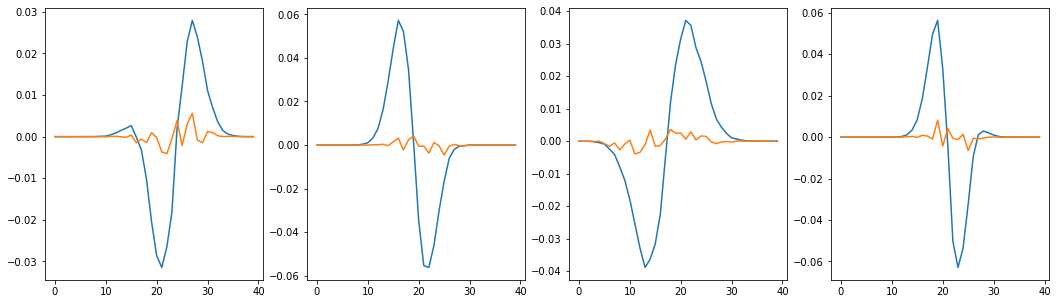

In [28]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

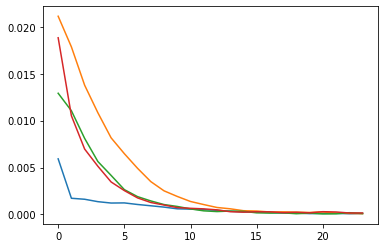

In [29]:
plt.plot( det_hist_data_sum_diff2)

In [30]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.999  rms 0.858      step 2 mean  0.999  rms 0.465
  iter  1 : step 1 mean  0.899  rms 0.595      step 2 mean  0.897  rms 0.256
  iter  2 : step 1 mean  0.892  rms 0.484      step 2 mean  0.889  rms 0.190
  iter  3 : step 1 mean  0.886  rms 0.409      step 2 mean  0.883  rms 0.161
  iter  4 : step 1 mean  0.880  rms 0.351      step 2 mean  0.877  rms 0.141
  iter  5 : step 1 mean  0.894  rms 0.308      step 2 mean  0.891  rms 0.125
  iter  6 : step 1 mean  0.885  rms 0.265      step 2 mean  0.885  rms 0.111
  iter  7 : step 1 mean  0.891  rms 0.234      step 2 mean  0.890  rms 0.103
  iter  8 : step 1 mean  0.895  rms 0.205      step 2 mean  0.893  rms 0.091
  iter  9 : step 1 mean  0.910  rms 0.187      step 2 mean  0.910  rms 0.090
  iter 10 : step 1 mean  0.914  rms 0.166      step 2 mean  0.911  rms 0.078
  iter 11 : step 1 mean  0.923  rms 0.146      step 2 mean  0.924  rms 0.068
  iter 12 : step 1 mean  0.920  rms 0.134      step 2 mean  0.920  rms 0.066

<function matplotlib.pyplot.show(close=None, block=None)>

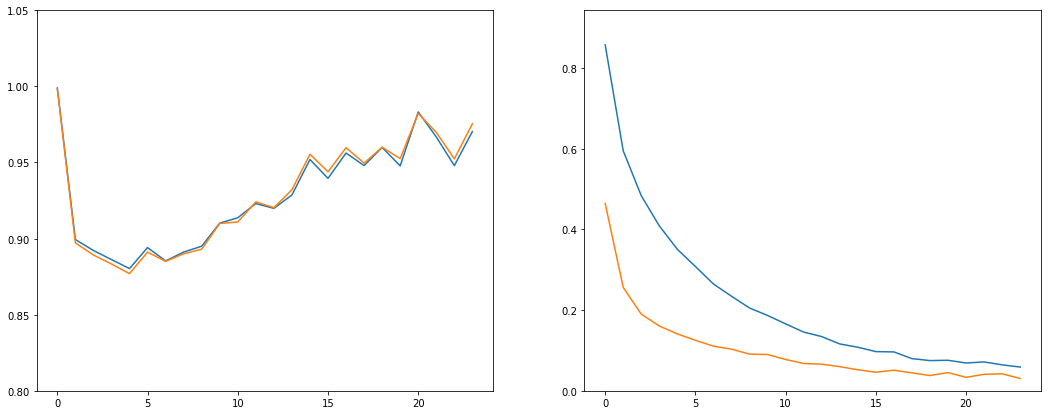

In [31]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show